In [1]:
import numpy as np
import kgeo
import xarray as xr
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.animation import FuncAnimation

In [15]:
def ds_to_geo(dataset):
    ds = dataset.transpose('geo', 'pix')
    geo = kgeo.kerr_raytracing_utils.Geodesics(
        a=float(ds.spin),
        observer_coords=[0,  float(ds.r_o), float(ds.inc), 0],
        image_coords=[ds.alpha.data, ds.beta.data],
        mino_times=ds.mino.data,
        affine_times=ds.affine.data,
        geo_coords=[ds.t.data, ds.r.data, geos.th_s, ds.phi.data]
    )
    return geo

def init_figure(spin, xlim=[-8,8], ylim=[-8,8]):
    fig, ax = plt.subplots()
    ax.set_title(r'$a={}$'.format(spin))
    ln1, = ax.plot([], [], label='interp')
    ln2, = ax.plot([], [], '--', label='exact')
    rplus  =  1 + np.sqrt(1-spin**2)
    horizon = plt.Circle((0, 0), rplus, color='black')
    ax.add_patch(horizon)
    plt.legend()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    return fig, ax, ln1, ln2

def animate_rays(exact_ds, interp_ds, spin, fps=10):
    fig, ax, ln1, ln2 = init_figure(spin)
    def update(pix):
        ln1.set_data(interp_ds.sel(pix=pix).x, interp_ds.sel(pix=pix).y)
        ln2.set_data(exact_ds.sel(pix=pix).x, exact_ds.sel(pix=pix).y)
        ax.set_title(r'$a={}$; pix={}'.format(spin, pix))
        return [ln1, ln2]
    anim = FuncAnimation(fig, update, frames=npix,  interval=1e3 / fps)
    return anim

In [3]:
npix = 64
ngeo = 200
inclination = np.pi/2
distance = 1000.0
image_coords = [np.linspace(-8.0,8.0,npix), np.zeros(npix)]
observer_coords=[0, distance, inclination, 0]

In [4]:
num_spins = 100

rays = []
for spin in tqdm(np.linspace(1e-6, 0.94, num_spins)):
    geos = kgeo.raytrace_ana(spin, observer_coords, image_coords, ngeo, plotdata=False, verbose=False)
    rays.append(geos.get_dataset())
rays = xr.concat(rays, dim='spin')

  0%|          | 0/100 [00:00<?, ?it/s]

/home/aviad/anaconda3/envs/bhnerf/lib/python3.8/site-packages/kgeo/scipy_ellip_binding.py:214: RuntimeWarning: divide by zero encountered in true_divide
  p_m = (z_m*(x_m+y_m+q_m) - x_m*y_m) / (z_m + q_m)
/home/aviad/anaconda3/envs/bhnerf/lib/python3.8/site-packages/kgeo/scipy_ellip_binding.py:214: RuntimeWarning: invalid value encountered in true_divide
  p_m = (z_m*(x_m+y_m+q_m) - x_m*y_m) / (z_m + q_m)
/home/aviad/anaconda3/envs/bhnerf/lib/python3.8/site-packages/kgeo/kerr_raytracing_utils.py:206: RuntimeWarning: invalid value encountered in cos
  'x': (['geo', 'pix'],  self.r_s * np.cos(self.ph_s) * np.sin(self.th_s)),
/home/aviad/anaconda3/envs/bhnerf/lib/python3.8/site-packages/kgeo/kerr_raytracing_utils.py:207: RuntimeWarning: invalid value encountered in sin
  'y': (['geo', 'pix'],  self.r_s * np.sin(self.ph_s) * np.sin(self.th_s)),


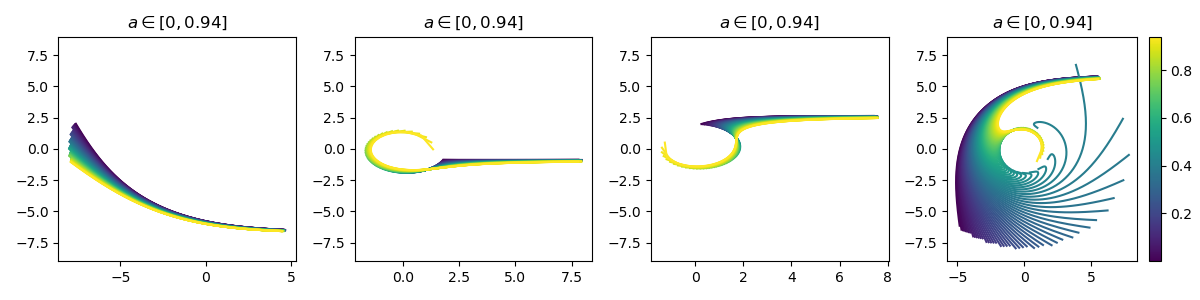

In [5]:
"""
Plot trajectories of 4 image pixels for different spin values
"""
max_r = 8.0
trajectories = rays.sel(pix=[5, 28, 42, 55])

cmap = plt.cm.viridis(np.linspace(0, 1, rays.spin.size))
sm = plt.cm.ScalarMappable(cmap='viridis', norm=Normalize(rays.spin.min(), rays.spin.max()))
%matplotlib widget

fig, axes = plt.subplots(1, 4, figsize=(12,3))
for i in trajectories.pix:
    for spin, color in zip(trajectories.sel(pix=i).spin, cmap):
        traject = trajectories.where(trajectories.r < max_r).sel(geo=range(ngeo-1), pix=i, spin=spin)
        x, y = traject.x, traject.y
        axes[i].plot(x, y, color=color)
        axes[i].set_title(r'$a \in [0,0.94]$')
        axes[i].set_ylim([-9, 9])
plt.tight_layout()
plt.colorbar(sm)

plotting data...
maxwraps  3


/home/aviad/anaconda3/envs/bhnerf/lib/python3.8/site-packages/kgeo/scipy_ellip_binding.py:214: RuntimeWarning: divide by zero encountered in true_divide
  p_m = (z_m*(x_m+y_m+q_m) - x_m*y_m) / (z_m + q_m)
/home/aviad/anaconda3/envs/bhnerf/lib/python3.8/site-packages/kgeo/scipy_ellip_binding.py:214: RuntimeWarning: invalid value encountered in true_divide
  p_m = (z_m*(x_m+y_m+q_m) - x_m*y_m) / (z_m + q_m)
/home/aviad/anaconda3/envs/bhnerf/lib/python3.8/site-packages/kgeo/kerr_raytracing_utils.py:570: RuntimeWarning: invalid value encountered in true_divide
  nmax_eq = ((tau*np.sqrt(-a2u_minus.astype(complex)) + s_o*F_o) / (2*K))  + 1


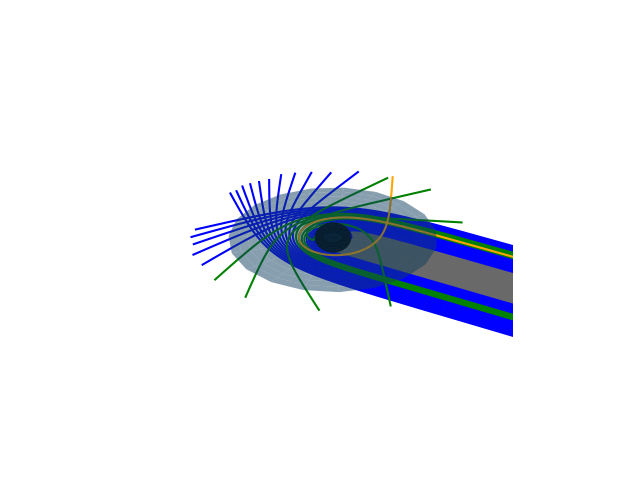

In [72]:
spin = 0.4
geo = kgeo.raytrace_ana(spin, observer_coords, image_coords, ngeo, plotdata=True, verbose=False)
geo_ds = geo.get_dataset().where(geo_interp_ds.r < max_r).sel(geo=range(ngeo-1))

maxwraps  3


/home/aviad/anaconda3/envs/bhnerf/lib/python3.8/site-packages/kgeo/kerr_raytracing_utils.py:570: RuntimeWarning: invalid value encountered in true_divide
  nmax_eq = ((tau*np.sqrt(-a2u_minus.astype(complex)) + s_o*F_o) / (2*K))  + 1


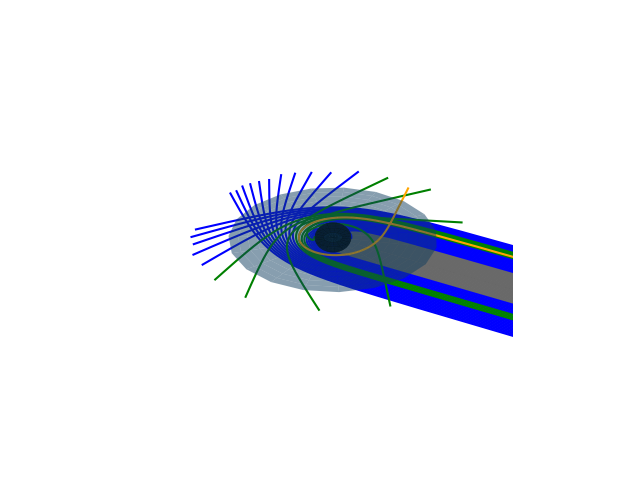

In [75]:
geo_interp_ds = rays.interp(spin=spin)
geo_interp = ds_to_geo(geo_interp_ds)
geo_interp.plotgeos()
geo_interp_ds = geo_interp_ds.where(geo_interp_ds.r < max_r).sel(geo=range(ngeo-1))

/home/aviad/anaconda3/envs/bhnerf/lib/python3.8/site-packages/kgeo/scipy_ellip_binding.py:214: RuntimeWarning: divide by zero encountered in true_divide
  p_m = (z_m*(x_m+y_m+q_m) - x_m*y_m) / (z_m + q_m)
/home/aviad/anaconda3/envs/bhnerf/lib/python3.8/site-packages/kgeo/scipy_ellip_binding.py:214: RuntimeWarning: invalid value encountered in true_divide
  p_m = (z_m*(x_m+y_m+q_m) - x_m*y_m) / (z_m + q_m)


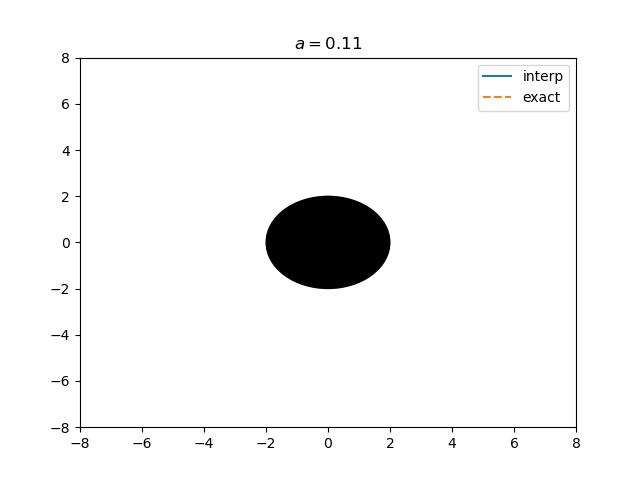

In [16]:
%matplotlib widget
spin = 0.11
max_r = 10.0

geo = kgeo.raytrace_ana(spin, observer_coords, image_coords, ngeo, plotdata=False, verbose=False).get_dataset()
exact_ds = geo.where(geo.r < max_r).sel(geo=range(ngeo-1))
interp_ds = rays.interp(spin=spin).where(geo.r < max_r).sel(geo=range(ngeo-1))
    
anim = animate_rays(exact_ds, interp_ds, spin=spin, fps=5)
outpath = 'spin_interpolation/th_0{:1.2f}.spin{:1.2f}.gif'.format(inclination, spin)
# anim.save(outpath, writer='imagemagick', fps=5)

In [17]:
from ipywidgets import interact
import ipywidgets as widgets

fig, ax, ln1, ln2 = init_figure(spin)
@interact(pix=widgets.IntSlider(min=0, max=npix-1, step=1, value=0))
def update(pix):
    ln1.set_data(interp_ds.sel(pix=pix).x, interp_ds.sel(pix=pix).y)
    ln2.set_data(exact_ds.sel(pix=pix).x, exact_ds.sel(pix=pix).y)
    ax.set_title(r'$a={}$; pix={}'.format(spin, pix))
    plt.show()

interactive(children=(IntSlider(value=0, description='pix', max=63), Output()), _dom_classes=('widget-interact…